In [121]:
import torch
import os

In [122]:
!ls /home/itdfh/data/dfdc-subset/train_spectrograms_part-5/real/ | head -10

ls: cannot access /home/itdfh/data/dfdc-subset/train_spectrograms_part-5/real/: No such file or directory


In [137]:
def get_feats(directory, nfirst=25, feats=700):
    vidpaths = sorted([os.path.join(directory, p) for p in os.listdir(directory)])

    samples = []
    for vp in vidpaths:
        samples.extend([os.path.join(vp, p) for p in sorted(os.listdir(vp)) if p[-5:] == '24.pt'])
        
    samples = samples[:nfirst]
    return torch.stack([torch.load(sample, map_location=torch.device('cpu'))[:,:feats] for sample in samples])

In [138]:
data_spec = get_feats('/home/itdfh/data/dfdc-subset/train_spectrograms_part-5/fake/')
data_spec.shape

torch.Size([25, 24, 700])

In [140]:
data_xcep = get_feats('/home/itdfh/data/dfdc-subset/train_xception_part-5/fake/', feats=2048)
data_xcep.shape

torch.Size([25, 24, 2048])

In [141]:
data = torch.cat([data_xcep, data_spec], dim=-1)
data.shape

torch.Size([25, 24, 2748])

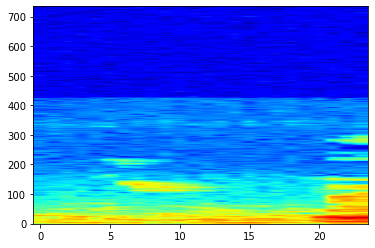

In [120]:
import matplotlib.pyplot as plt

# t = t.numpy()
plt.imshow(t.transpose(), aspect='auto', origin='bottom', cmap='jet')